### 모델링

0 : S Class Challenge, 1 : Knock Challenge

In [1]:
import pandas as pd

df = pd.read_csv("./data/train.csv")
df

,LEFT_SHOULDER-LEFT_SHOULDER angle,LEFT_SHOULDER-RIGHT_SHOULDER angle,RIGHT_SHOULDER-LEFT_ELBOW angle,LEFT_ELBOW-RIGHT_ELBOW angle,RIGHT_ELBOW-RIGHT_ELBOW angle,RIGHT_ELBOW-LEFT_WRIST angle,LEFT_WRIST-RIGHT_WRIST angle,RIGHT_WRIST-LEFT_PINKY angle,LEFT_PINKY-LEFT_PINKY angle,LEFT_PINKY-RIGHT_PINKY angle,...,LEFT_KNEE-RIGHT_KNEE angle,RIGHT_KNEE-RIGHT_KNEE angle,RIGHT_KNEE-LEFT_ANKLE angle,LEFT_ANKLE-RIGHT_ANKLE angle,RIGHT_ANKLE-LEFT_HEEL angle,LEFT_HEEL-LEFT_HEEL angle,LEFT_HEEL-RIGHT_HEEL angle,RIGHT_HEEL-LEFT_FOOT_INDEX angle,LEFT_FOOT_INDEX-RIGHT_FOOT_INDEX angle,label
0,69.375926,64.035946,95.428139,91.315000,59.431206,79.368860,148.086843,76.435642,102.340267,29.020153,...,85.182365,60.649068,20.103244,92.768428,47.810383,76.408244,52.426816,41.128237,88.042094,0
1,69.474760,64.523473,99.791412,102.232657,78.027418,85.047407,148.482816,107.699759,108.391325,76.201572,...,78.955794,69.691130,37.762611,57.143315,60.262681,68.340358,37.030090,55.251202,80.353901,0
2,69.097092,65.309728,99.057792,99.119320,73.243418,85.875662,153.637611,99.734852,109.392901,68.348583,...,80.983527,71.255689,30.068351,65.757420,63.860163,71.443968,28.728012,64.424498,83.470905,0
3,68.809699,65.849288,97.052322,96.095160,72.707062,82.769050,153.023194,99.155531,106.026145,68.276766,...,82.153196,70.375918,31.466907,63.590647,61.691069,72.211328,38.574323,53.367904,84.715894,0
4,69.038694,67.971478,101.202624,97.460160,70.573823,88.536700,156.622183,96.640056,112.508262,68.937323,...,82.880140,77.134506,27.828227,67.453285,69.489284,73.318917,18.334687,76.207942,85.784184,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,32.142901,80.219598,74.574904,32.946067,56.841026,28.226418,17.571157,50.325116,30.249248,16.418872,...,57.658905,61.063092,34.518871,50.317904,62.316472,45.010314,46.335060,62.859446,62.850589,1
976,32.846283,80.572144,88.546805,41.299344,54.198901,60.726957,48.577747,65.290688,55.607233,6.895463,...,54.640074,59.475683,31.664125,43.008279,55.823249,41.524264,43.115963,54.872029,54.870254,1
977,32.988359,80.925901,89.503061,43.845291,54.799507,65.270252,54.494942,70.905477,60.257130,12.082097,...,55.545555,59.054495,32.689395,40.855758,51.410594,41.943385,40.922187,51.176072,54.918894,1
978,32.915550,80.235997,86.154742,43.499635,54.629767,61.904178,52.436874,70.764231,58.259966,16.342790,...,57.123310,60.185301,34.643805,44.104849,53.163478,43.877882,42.677293,53.398092,58.691476,1


In [2]:
df["label"].value_counts()

0    574
1    406
Name: label, dtype: int64

### 머신러닝 알고리즘부터

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = df.drop(columns=["label"], axis = 1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [4]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(686, 28) (294, 28)
(686,) (294,)


### LogisticRegression

In [5]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(n_jobs = -1, random_state=22)

### GridSearchCV
GridSearchCV로 교차검증을 진행함과 동시에 하이퍼 파라미터 탐색을 통해 모델 최적화

In [6]:
params = {
    "C" : [1, 1.5, 2.0, 2.5, 3.0],
    "max_iter" : [100, 300, 500, 700, 900]
}

log_grid = GridSearchCV(log, param_grid=params, n_jobs=-1, cv = 10)
log_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=22),
             n_jobs=-1,
             param_grid={'C': [1, 1.5, 2.0, 2.5, 3.0],
                         'max_iter': [100, 300, 500, 700, 900]})

### 정확도 책정


In [7]:
from sklearn.metrics import accuracy_score 

y_pred = log_grid.best_estimator_.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(acc) # 모델의 성능(정확도)

0.9693877551020408


### 임의의 데이터에 대한 평가

In [8]:
val_data = pd.read_csv("./data/validation.csv") # 훈련 시 사용하지 않은 데이터
val_data["label"] = 1
val_data1 = val_data.drop(columns=["label"], inplace=False)
val_target1 = val_data["label"]

In [17]:
y_pred = log_grid.best_estimator_.predict(val_data1)
acc = accuracy_score(val_target1, y_pred)
acc # 68퍼센트이기에 1의 라벨에 가깝다는 결과라고 할 수 있다. 

# 정확도를 나타내려면?
abs(0.5 - round(acc, 2))*2

0.3600000000000001

### 신경망 모델링

In [10]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout
import numpy as np, tensorflow as tf

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(686, 28) (294, 28)
(686, 1) (294, 1)


### 직접 빌드
functional api method로 모델 구성

In [11]:
input_ = Input(shape = (28, ))
x = Dense(256, activation = "relu")(input_)
x = Dropout(rate = 0.3)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(rate = 0.3)(x)
x = Dense(64, activation = "relu")(x)
output_ = Dense(1, activation = "sigmoid")(x)

model = Model(input_, output_)
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = "binary_crossentropy", metrics=['acc'])
model.summary() # 모델 계층도 출력

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 256)               7424      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65    

### 콜백함수 정의

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import os

save_model = ModelCheckpoint("./model/weights/self-build-{epoch:02d}.hdf5", monitor = "val_loss", mode = "min", save_best_only = True)
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", mode = "min", patience = 5, factor = 0.01)

if not os.path.isdir("./model/"):
    os.mkdir('./model')
csv_logging = CSVLogger('./model/self-build history.csv') # csv logger의 경우 디렉토리가 존재하지 않으면 오류가 발생한다.

callbacks = [save_model, early_stop, reduce_lr, csv_logging]

In [13]:
model.fit(x = x_train, y = y_train, epochs=150, callbacks = callbacks, validation_data = (x_test, y_test))

Epoch 1/150
22/22 [==============================] - 2s 12ms/step - loss: 4.3276 - acc: 0.6152 - val_loss: 0.8634 - val_acc: 0.7687 - lr: 0.0010
Epoch 2/150
22/22 [==============================] - 0s 5ms/step - loss: 1.6568 - acc: 0.6603 - val_loss: 0.4119 - val_acc: 0.8503 - lr: 0.0010
Epoch 3/150
22/22 [==============================] - 0s 5ms/step - loss: 1.0797 - acc: 0.6997 - val_loss: 0.3641 - val_acc: 0.8537 - lr: 0.0010
Epoch 4/150
22/22 [==============================] - 0s 5ms/step - loss: 0.8531 - acc: 0.7449 - val_loss: 0.3143 - val_acc: 0.8605 - lr: 0.0010
Epoch 5/150
22/22 [==============================] - 0s 4ms/step - loss: 0.7359 - acc: 0.7507 - val_loss: 0.3448 - val_acc: 0.8197 - lr: 0.0010
Epoch 6/150
22/22 [==============================] - 0s 4ms/step - loss: 0.5981 - acc: 0.7653 - val_loss: 0.3277 - val_acc: 0.8844 - lr: 0.0010
Epoch 7/150
22/22 [==============================] - 0s 4ms/step - loss: 0.5022 - acc: 0.8163 - val_loss: 0.3316 - val_acc: 0.8537 - lr

### 학습곡선 가시화

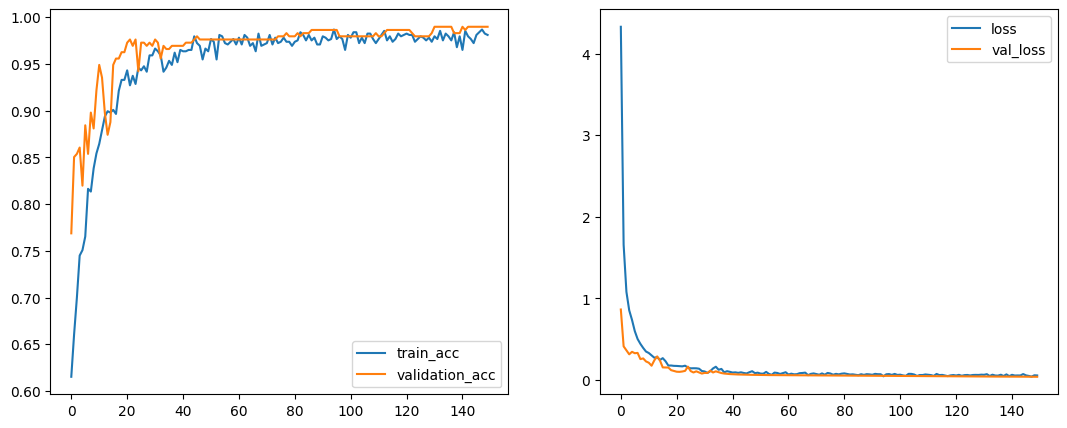

In [14]:
import matplotlib.pyplot as plt

predicted_data = pd.read_csv("./model/self-build history.csv")

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(predicted_data["epoch"], predicted_data["acc"], label = "train_acc")
plt.plot(predicted_data["epoch"], predicted_data["val_acc"], label = "validation_acc")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(predicted_data["epoch"], predicted_data["loss"], label = "loss")
plt.plot(predicted_data["epoch"], predicted_data["val_loss"], label = "val_loss")
plt.legend()

### 학습에 사용하지 않은 데이터에 대한 예측

In [32]:
val_data = pd.read_csv('./data/validation.csv')
val_data["label"] = 1
val_data_x = val_data.drop(columns=["label"]).values
val_data_y = val_data[["label"]].values

print(val_data_x.shape, val_data_y.shape)
val_data_x

(492, 28) (492, 1)


array([[ 33.76134972,  70.43878317,  66.00748755, ...,  40.28644475,
         61.1834271 ,  85.26218183],
       [ 39.5271981 ,  73.98750269,  71.77367882, ...,  36.89364937,
         55.29970405,  80.49769637],
       [ 41.7994479 ,  75.88077438,  74.40065187, ...,  32.92949717,
         47.18372936,  71.12151876],
       ...,
       [ 77.6847267 ,  82.40981101, 112.4751869 , ...,  40.24789139,
         14.91760858,  44.6957549 ],
       [ 85.06398036,  87.49487974, 118.33337378, ...,  45.4821892 ,
         22.80507805,  39.5609903 ],
       [104.83512654, 104.17725675, 139.31789643, ...,  54.4931692 ,
         36.09429451,  44.81248038]])

In [36]:
np.mean(model.predict(val_data_x))

16/16 [==============================] - 0s 1ms/step


0.5544443

### 의문점
1. 데이터의 경우 시간이 경과함에 따라 관절각도도 달라지기 마련인데 이런식의 예측이 맞는가..? 정확도는 왜 잘나오는거며..
2. 얼굴을 제외한 모든 관절들에 대한 각도를 구하는게 맞는가..?